# Predicting Stroke Risk

Strokes represent a significant public health challenge, with their numbers surpassing that of cancer-related fatalities every year. The timely identification of individuals with high risk of strokes is paramount for implementing preemptive interventions and reducing the incidence of strokes in the future. Leveraging our analysis from our dataset offers a promising avenue for addressing this critical health concern.

## Exploring our Data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency

In [3]:
df = pd.read_csv('strokesdataset.csv')

In [4]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 43400 non-null  int64  
 1   gender             43400 non-null  object 
 2   age                43400 non-null  float64
 3   hypertension       43400 non-null  int64  
 4   heart_disease      43400 non-null  int64  
 5   ever_married       43400 non-null  object 
 6   work_type          43400 non-null  object 
 7   Residence_type     43400 non-null  object 
 8   avg_glucose_level  43400 non-null  float64
 9   bmi                41938 non-null  float64
 10  smoking_status     30108 non-null  object 
 11  stroke             43400 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


Our dataset comprises a combination of numerical and categorical features, with 'stroke' serving as our target column. Among the numerical features, we observe 'Id', 'hypertension', 'heart_disease', and 'stroke' represented as integers. On the categorical side, 'Gender', 'ever_married', 'work_type', 'residence_type', and 'smoking_status' are objects. Additionally, 'Age', 'avg_glucose_level', and 'bmi' are recorded as floats, reflecting continuous variables.

Additionally, there are missing values in the 'smoking_status' and 'bmi' columns, which could potentially impact our analysis. 

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,43400.0,36326.142350,21072.134879,1.00,18038.50,36351.50,54514.25,72943.00
age,43400.0,42.217894,22.519649,0.08,24.00,44.00,60.00,82.00
hypertension,43400.0,0.093571,0.291235,0.00,0.00,0.00,0.00,1.00
heart_disease,43400.0,0.047512,0.212733,0.00,0.00,0.00,0.00,1.00
avg_glucose_level,43400.0,104.482750,43.111751,55.00,77.54,91.58,112.07,291.05
bmi,41938.0,28.605038,7.770020,10.10,23.20,27.70,32.90,97.60
stroke,43400.0,0.018041,0.133103,0.00,0.00,0.00,0.00,1.00


In [7]:
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis = 1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending=False)

,count,%
smoking_status,13292,30.626728
bmi,1462,3.368664
id,0,0.000000
gender,0,0.000000
age,0,0.000000
hypertension,0,0.000000
heart_disease,0,0.000000
ever_married,0,0.000000
work_type,0,0.000000
Residence_type,0,0.000000


Handling missing data appropriately will be crucial to ensure the accuracy and reliability of our predictive models. We can consider techniques such as imputation or exclusion based on the extent of missingness and the nature of the dataset.

For the 'smoking_status' column with >30% missing data:
Since 'smoking_status' is a categorical variable, we can replace missing values with random values in the given ratio of our current data.

For the 'bmi' column with >3.3% missing data:
Since 'bmi' is a numerical variable, we can replace missing values with the median of the column, which is less sensitive to outliers compared to the mean. 

In [8]:
df['smoking_status'].value_counts()

smoking_status
never smoked       16053
formerly smoked     7493
smokes              6562
Name: count, dtype: int64

We have our smoking_status data in a ratio of 53.3% never smoked, 24.9% formerly smoked, and 21.8% smokes. We will use these ratios to fill in our missing values.

In [9]:
ratios = {'never smoked': 53.3, 'formerly smoked': 24.9, 'smokes': 21.8}

# Function to fill missing values based on given ratios
def fill_missing_smoking(row):
    if pd.isna(row['smoking_status']):
        return np.random.choice(list(ratios.keys()), p=[v/100 for v in ratios.values()])
    else:
        return row['smoking_status']

# Apply function to fill missing values
df['smoking_status'] = df.apply(fill_missing_smoking, axis=1)

In [10]:
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis = 1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending=False)

,count,%
bmi,1462,3.368664
id,0,0.000000
gender,0,0.000000
age,0,0.000000
hypertension,0,0.000000
heart_disease,0,0.000000
ever_married,0,0.000000
work_type,0,0.000000
Residence_type,0,0.000000
avg_glucose_level,0,0.000000


In [11]:
df['smoking_status'].value_counts()

smoking_status
never smoked       23138
formerly smoked    10803
smokes              9459
Name: count, dtype: int64

We have successfully addressed all missing values within the smoking_status column, ensuring completeness of our dataset. The replacement of missing values has been executed proportionately, maintaining the original distribution. Given that approximately 30% of our data was initially absent in this column, it is imperative to conduct a thorough evaluation of its impact on our analytical outcomes.

We will now address our missing data in the BMI coulmn.

In [12]:
#Fill in missing values for BMI column using median
def fill_missing_bmi(row):
    if pd.isna(row['bmi']):
        return df['bmi'].median()
    else:
        return row['bmi']

# Apply function to fill missing values
df['bmi'] = df.apply(fill_missing_bmi, axis=1)

In [13]:
#Evaluate misssing data counts
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis = 1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending=False)

,count,%
id,0,0.0
gender,0,0.0
age,0,0.0
hypertension,0,0.0
heart_disease,0,0.0
ever_married,0,0.0
work_type,0,0.0
Residence_type,0,0.0
avg_glucose_level,0,0.0
bmi,0,0.0


We have effectively imputed missing values in the BMI column, employing the median to mitigate potential distortions in the dataset. Notably, the absence of data amounted to only 3% of our overall dataset, suggesting minimal impact on analytical outcomes. Nonetheless, a comprehensive reassessment is warranted to ensure the integrity of our results.

## Visualization

Now that our dataset is complete, we will proceed with visualizing our columns and examining their relationship with the stroke column. This analysis aims to identify any potential correlations between variables and the occurrence of strokes.

### Age

Text(0, 0.5, 'Count')

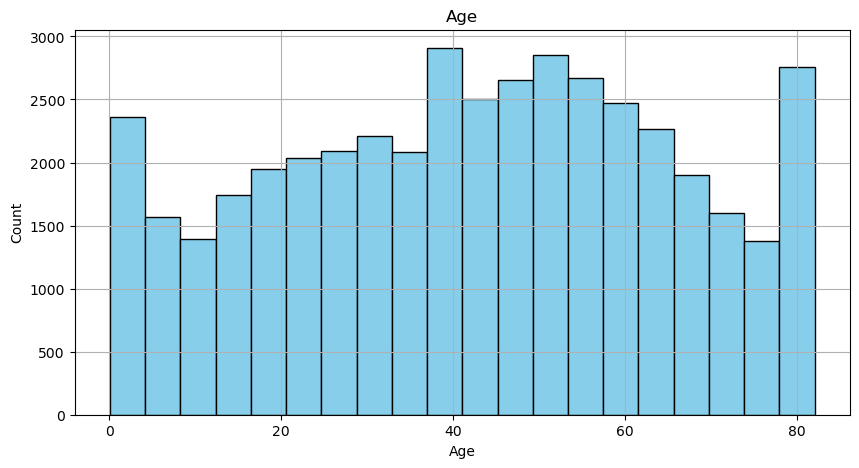

In [14]:
#Graphing all columns to see distrubution of data starting with age
aa = df['age'].hist(figsize=(10,5), bins = 20, edgecolor = 'black', color = 'skyblue')

# Set titles and labels
aa.set_title('Age')
aa.set_xlabel('Age')
aa.set_ylabel('Count')

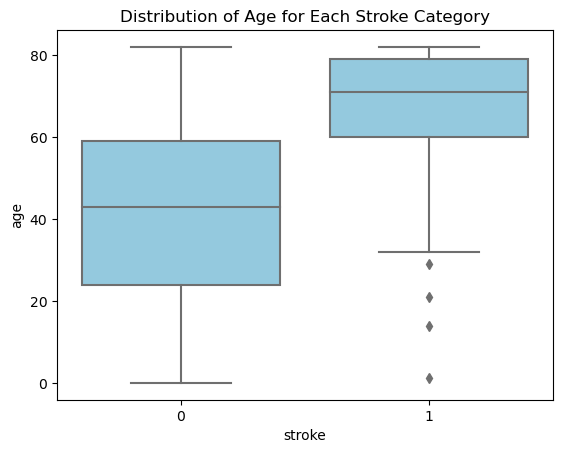

In [15]:
# Create a boxplot showing the distribution of age for each target category
sns.boxplot(x='stroke', y='age', data=df, color = 'skyblue')
plt.title('Distribution of Age for Each Stroke Category')
plt.show()

We observe a well-balanced age distribution spanning from infancy at 0.8 years (9.5 months) to adulthood at 82 years old. 

We also observe that there appears to be a notable disparity between the average age of individuals who have experienced a stroke and the overall average age within our dataset. This discrepancy suggests a potential correlation wherein higher age might predispose individuals to strokes. However, to precisely quantify and establish the extent of this correlation, rigorous statistical analysis is required.

In [16]:
#Perform ttest on age separating stroke groups 
A1 = df[df['stroke'] == 1] ['age'] #age of people who have had a stroke
A2 = df[df['stroke'] == 0] ['age']#age of people who have not had a stroke
stats.ttest_ind(A1, A2)

TtestResult(statistic=32.91160061215167, pvalue=1.1715396598877709e-234, df=43398.0)

Given the extremely small p-value, we conclude that there is a significant difference in mean age between the two groups. This suggests that age could serve as a significant predictor of stroke risk in our dataset.

However, it's essential to conduct further analysis to explore potential confounding variables and verify the robustness of this relationship. Multivariate analysis and considering other health factors alongside age would provide a more comprehensive understanding of the predictors of stroke risk.

### BMI

Text(0, 0.5, 'Count')

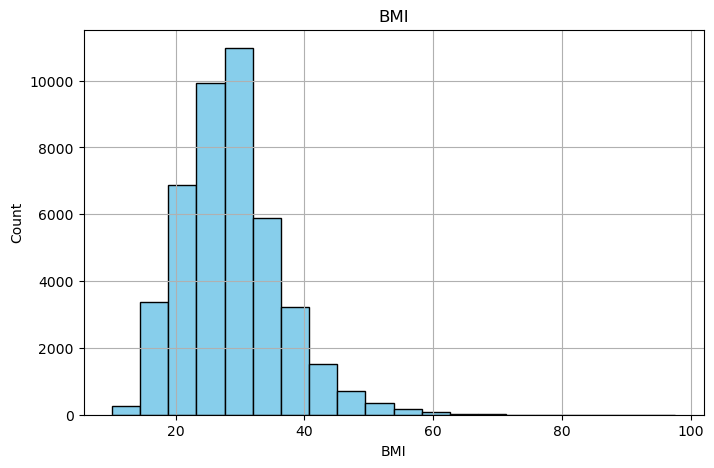

In [17]:
#Visually inspect BMI column
ab = df['bmi'].hist(figsize=(8,5), bins = 20, edgecolor = 'black', color = 'skyblue')

# Set titles and labels
ab.set_title('BMI')
ab.set_xlabel('BMI')
ab.set_ylabel('Count')

Our graph exhibits a slight right skew, indicating a few BMI values towards the higher end. Notably, there are a few BMI entries that surpass the norm, with a maximum recorded value of 97.6. While this is still within the possoiblities of a bmi value, it is still viewed as a significant outlier.

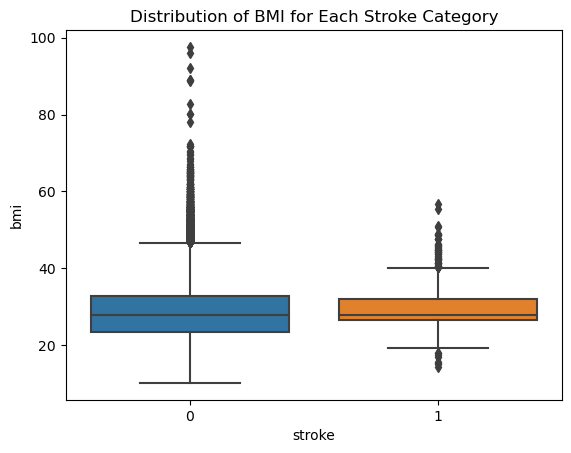

In [18]:
# Create a boxplot showing the distribution of BMI for each target category
sns.boxplot(x='stroke', y='bmi', data=df)
plt.title('Distribution of BMI for Each Stroke Category')
plt.show()

Upon examination of our BMI column, it is evident that numerous outliers exist beyond the bounds of our boxplot. Interestingly, individuals who have encountered a stroke do not encompass some of the more extreme high BMI values observed. However, to ascertain any potential effects of BMI on stroke prediction with greater certainty, additional statistical tests are imperative. These tests will aid in elucidating the relationship between BMI and stroke occurrence.

In [19]:
#Perform ttest on bmi separating stroke groups 
B1 = df[df['stroke'] == 1] ['bmi'] #bmi of people who have had a stroke
B2 = df[df['stroke'] == 0] ['bmi']#bmi of people who have not had a stroke
stats.ttest_ind(B1, B2)

TtestResult(statistic=3.3488046716890953, pvalue=0.0008123003046563606, df=43398.0)

Although the p-value for BMI is not as remarkably low as that for age, it still falls within the range considered statistically significant. This indicates a noteworthy difference in mean BMI between individuals who experienced a stroke and those who did not. This finding highlights the importance of BMI as a potential predictor of stroke risk within our dataset.

### Average Glucose Levels

Text(0, 0.5, 'Count')

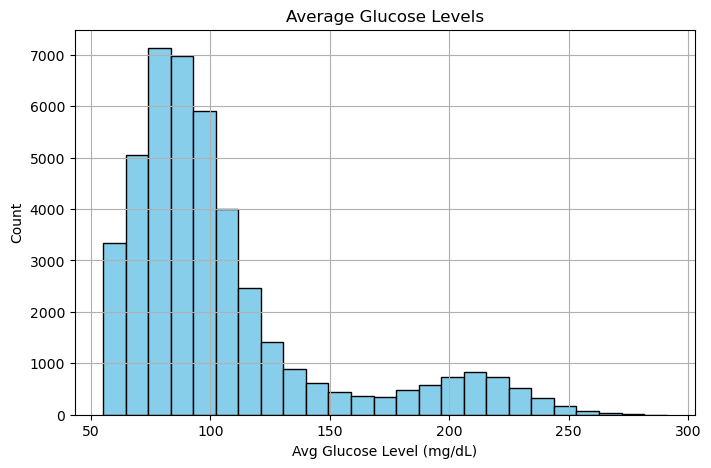

In [20]:
#Visually inspect the avg_glucose_level column
ag = df['avg_glucose_level'].hist(figsize=(8,5), bins = 25, edgecolor = 'black', color = 'skyblue')

# Set titles and labels
ag.set_title('Average Glucose Levels')
ag.set_xlabel('Avg Glucose Level (mg/dL)')
ag.set_ylabel('Count')

Our graph exhibits a slight right skew, mirroring the distribution of BMI values. Notably, our dataset reveals a minimum glucose level of 55.0 mg/dL and a maximum of 291.05 mg/dL. Recommended glucose levels typically range between 50-115 mg/dL for excellent health, while levels between 150-180 mg/dL are considered good. Values exceeding 215 mg/dL usually indicate a heightened risk of disease. Given this data, there's potential to explore whether elevated glucose levels can serve as predictors for a heightened risk of stroke.

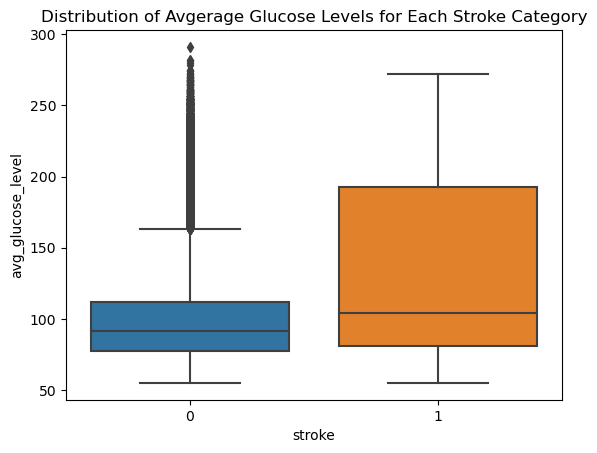

In [21]:
# Create a boxplot showing the distribution of average glucose level for each target category
sns.boxplot(x='stroke', y='avg_glucose_level', data=df)
plt.title('Distribution of Avgerage Glucose Levels for Each Stroke Category')
plt.show()

Upon juxtaposing our stroke column with the average glucose levels column, a significant disparity in glucose levels among individuals who have experienced a stroke is apparent. Notably, the interquartile range of glucose levels in stroke patients is notably broader compared to our entire dataset, encompassing the majority of outliers. This discrepancy suggests a potential association between glucose levels and stroke incidence. However, before drawing conclusive inferences, rigorous statistical testing is imperative to elucidate the precise relationship between glucose levels and stroke susceptibility.

In [22]:
#Perform ttest on average gluce level separating stroke groups 
G1 = df[df['stroke'] == 1] ['avg_glucose_level'] #avg_glucose_level of people who have had a stroke
G2 = df[df['stroke'] == 0] ['avg_glucose_level']#avg_glucose_level of people who have not had a stroke
stats.ttest_ind(G1, G2)

TtestResult(statistic=16.49159150818717, pvalue=6.466046156595364e-61, df=43398.0)

Following our t-test analysis of average glucose levels, we have established statistical significance indicating a difference in mean glucose levels between individuals who experienced a stroke and those who did not. This finding corroborates our observations from the bar graph visualization and provides robust statistical evidence supporting the association between glucose levels and stroke risk.

### Hypertension

Text(0, 0.5, 'Count')

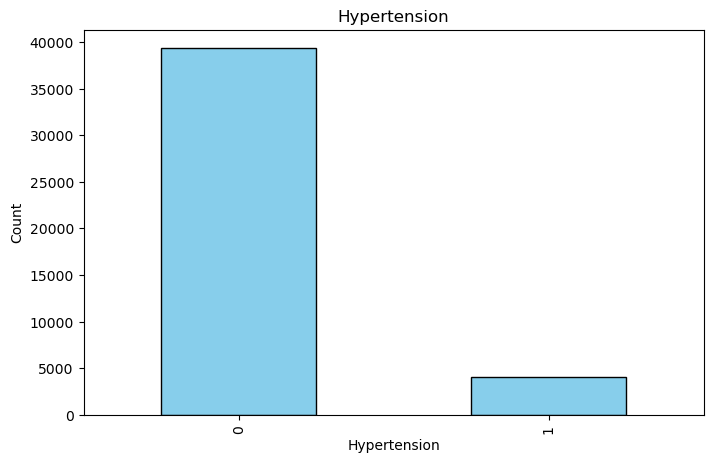

In [23]:
#Visually inspect hypertention column
ah = df['hypertension'].value_counts().plot(kind='bar', figsize=(8, 5), color = 'skyblue', edgecolor = 'black')

# Set titles and labels
ah.set_title('Hypertension')
ah.set_xlabel('Hypertension')
ah.set_ylabel('Count')

In [24]:
df['hypertension'].value_counts()

hypertension
0    39339
1     4061
Name: count, dtype: int64

Hypertension, characterized by a blood pressure reading of 130/80 mm Hg or higher,  can be a significant risk factor for stroke. However, our dataset only provides binary responses, indicating whether individuals have hypertension (1) or not (0), without offering the specific blood pressure values. With 4061 instances of hypertension recorded as 1, we can leverage this information to investigate the correlation between hypertension and stroke risk, despite the absence of precise blood pressure measurements in our dataset. 

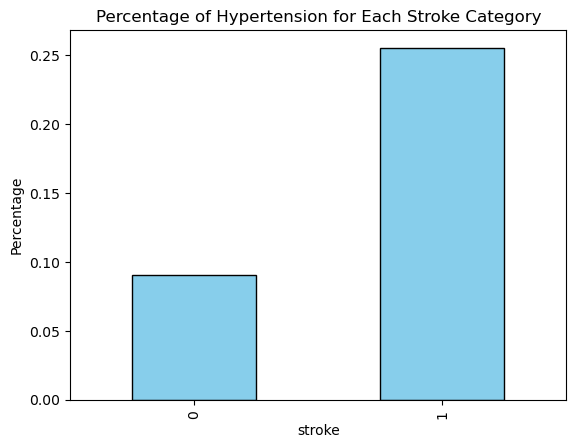

In [25]:
# Create a bar plot showing the percentage of Hypertension for each target category
df.groupby(['stroke']) ['hypertension'].mean().plot(kind='bar', edgecolor = 'black', color = 'skyblue')
plt.ylabel('Percentage')
plt.title('Percentage of Hypertension for Each Stroke Category')
#plt.legend(title='Hypertension')
plt.show()

In [26]:
df.groupby(['stroke']) ['hypertension'].mean()

stroke
0    0.090598
1    0.255428
Name: hypertension, dtype: float64

Within our dataset, a notable majority of individuals do not meet the criteria for hypertension. However, upon closer examination of hypertensive individuals, a substantial proportion have experienced both hypertension and stroke, compared to those with hypertension but no history of stroke.

In [27]:
#Perform ttest on hypertension separating stroke groups 
H1 = df[df['stroke'] == 1] ['hypertension'] #hypertension of people who have had a stroke
H2 = df[df['stroke'] == 0] ['hypertension'] #hypertension of people who have not had a stroke
stats.ttest_ind(H1, H2)

TtestResult(statistic=15.738074583072663, pvalue=1.1826077404516636e-55, df=43398.0)

Based on the T-test results, there is a statistically significant relationship between hypertension and stroke. The T-test statistic of 15.738 suggests a strong difference between the means of the two groups being compared (those with and without hypertension in relation to stroke occurrence). The extremely low p-value (1.1826e-55) indicates that this difference is highly unlikely to be due to random chance.

In summary, the T-test provides robust evidence that hypertension is significantly associated with an increased risk of stroke.

### Heart Disease

Text(0, 0.5, 'Count')

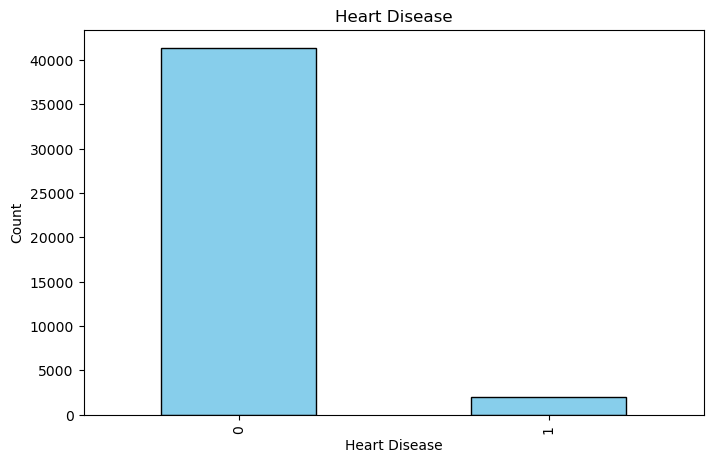

In [28]:
#Visually inspect heart disease column
ad = df['heart_disease'].value_counts().plot(kind='bar', figsize=(8, 5),  edgecolor = 'black', color = 'skyblue')

# Set titles and labels
ad.set_title('Heart Disease')
ad.set_xlabel('Heart Disease')
ad.set_ylabel('Count')

In [29]:
df['heart_disease'].value_counts()

heart_disease
0    41338
1     2062
Name: count, dtype: int64

In our dataset, we encounter a binary representation for the presence of heart disease, with a value of 1 indicating its presence (True) and 0 indicating its absence (False). However, the dataset lacks granularity regarding the specifics of the heart disease, such as its type, current status (active or resolved), or any associated details. Despite these limitations, we note the occurrence of 2062 instances where heart disease is recorded as True (1). 

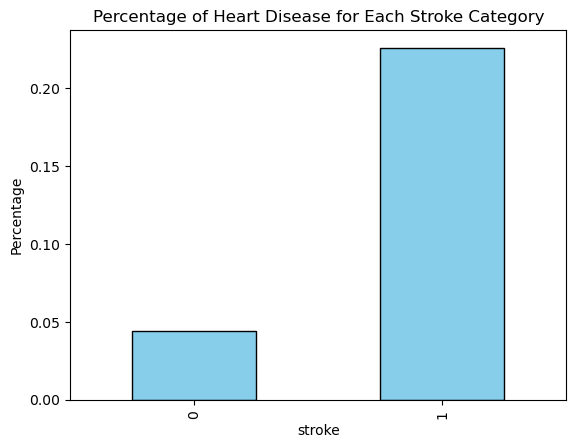

In [30]:
# Create a bar plot showing the percentage of heart disease for each target category
df.groupby(['stroke']) ['heart_disease'].mean().plot(kind='bar',  edgecolor = 'black', color = 'skyblue')
plt.ylabel('Percentage')
plt.title('Percentage of Heart Disease for Each Stroke Category')
#plt.legend(title='Heart Disease')
plt.show()

Simialrly to our hypertention analysis, our investigation reveals a notable correlation between individuals who have had heart disease and those who have experienced a stroke within our dataset. This observation suggests that the presence of heart disease may significantly influence stroke prediction. Moreover, the coherence between these findings and our hypertension results is logical, given the established relationship between hypertension and heart disease.

In [31]:
#Perform ttest on hypertension separating stroke groups 
HD1 = df[df['stroke'] == 1] ['heart_disease'] 
HD2 = df[df['stroke'] == 0] ['heart_disease'] 
stats.ttest_ind(HD1, HD2)

TtestResult(statistic=23.85417055505082, pvalue=5.861945318017253e-125, df=43398.0)

The T-test results for the relationship between heart disease and stroke indicate a highly significant association. The T-test statistic of 23.854 suggests a substantial difference between the means of the groups with and without heart disease concerning stroke occurrence. The p-value (5.8619e-125) is extremely low, indicating that this difference is not due to random chance.

In summary, the T-test demonstrates a strong and statistically significant relationship between heart disease and stroke. This suggests that individuals with heart disease are at a significantly higher risk of experiencing a stroke.

### Gender

Text(0, 0.5, 'Count')

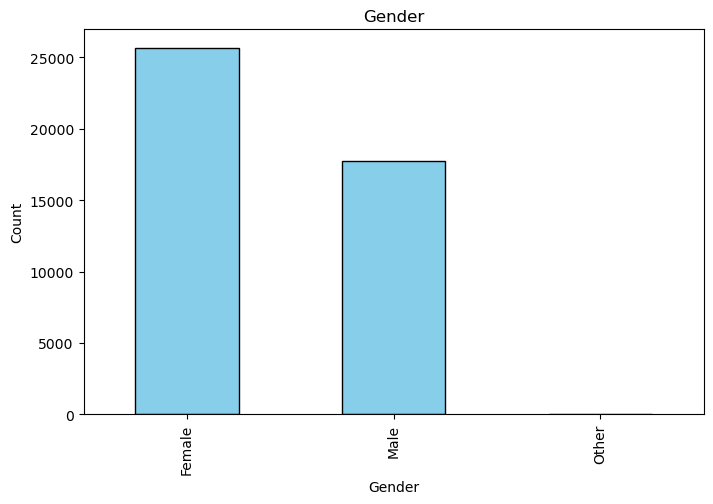

In [32]:
#Visually inspect Gender column
ag = df['gender'].value_counts().plot(kind='bar', figsize=(8, 5), edgecolor = 'black', color = 'skyblue')

# Set titles and labels
ag.set_title('Gender')
ag.set_xlabel('Gender')
ag.set_ylabel('Count')

In [33]:
df['gender'].value_counts()

gender
Female    25665
Male      17724
Other        11
Name: count, dtype: int64

We can see from our dataset that there's a notable gender imbalance, with females comprising approximately 59% of the data, males around 40%, and individuals categorized as "other" making up less than 1%. This distribution emphasizes the importance of considering gender disparities when analyzing the potential role of gender in predicting stroke occurrences. By acknowledging this demographic skew, we can ensure that our conclusions regarding gender-related patterns in stroke prediction are reflective of the dataset's information.

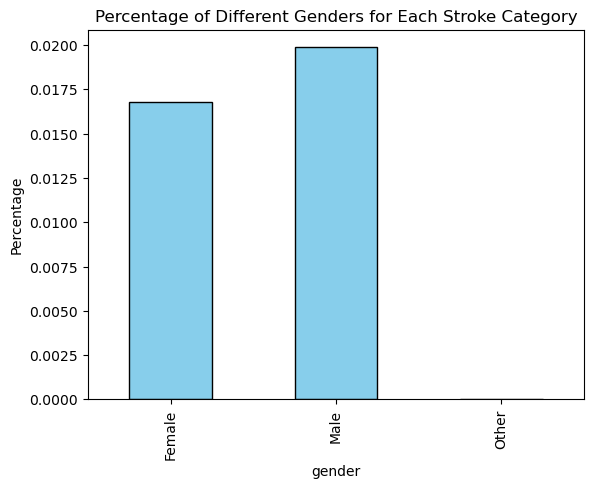

In [34]:
# Create a bar plot showing the percentage of different genders for each target category
df.groupby(['gender']) ['stroke'].mean().plot(kind='bar', edgecolor = 'black', color = 'skyblue')
plt.ylabel('Percentage')
plt.title('Percentage of Different Genders for Each Stroke Category')
#plt.legend(title='Gender')
plt.show()

As previously observed, our dataset comprises a greater number of females compared to males. However, upon examining the incidence of strokes by gender, we note a higher prevalence among males. This discrepancy suggests that gender may indeed play a role in stroke prediction. Further rigorous testing is necessary to elucidate the significance of gender as a predictive factor for strokes. Analyzing gender-specific trends and conducting statistical analyses will provide deeper insights into the relationship between gender and stroke incidence.

In [35]:
contingency_table = pd.crosstab(df['gender'], df['stroke'])

# Perform Chi-Squared Test
chi2_stat, p_val, _, _ = chi2_contingency(contingency_table)

# Print Chi-Square Statistic and p-value
print("Chi-Square Statistic:", chi2_stat)
print("p-value:", p_val)

Chi-Square Statistic: 5.767894799445178
p-value: 0.05591361325694649


The Chi-square statistic measures the extent of the association between gender and stroke. The p-value indicates the probability that the observed association could have occurred by chance.

In this case, the p-value is approximately 0.056, which is just above the commonly used significance threshold of 0.05. This suggests that there is not enough evidence to conclusively state that there is a statistically significant association between gender and stroke at the 5% significance level.

### Marital History

Text(0, 0.5, 'Count')

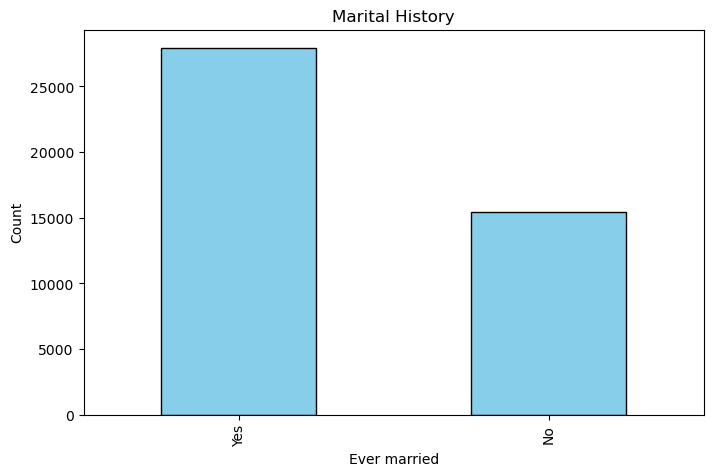

In [36]:
#Visually inspect marital history column
ag = df['ever_married'].value_counts().plot(kind='bar', figsize=(8, 5), edgecolor = 'black', color = 'skyblue')

# Set titles and labels
ag.set_title('Marital History')
ag.set_xlabel('Ever married')
ag.set_ylabel('Count')

In [37]:
df['ever_married'].value_counts()

ever_married
Yes    27938
No     15462
Name: count, dtype: int64

Our dataset indicates a higher prevalence of individuals categorized as married compared to those who were never married. While having additional information such as divorced status could potentially enrich our data analysis, we are constrained by the limitations of the provided dataset. Despite this constraint, we can still leverage the marital status data to explore potential relationships between marital status and stroke occurrences.

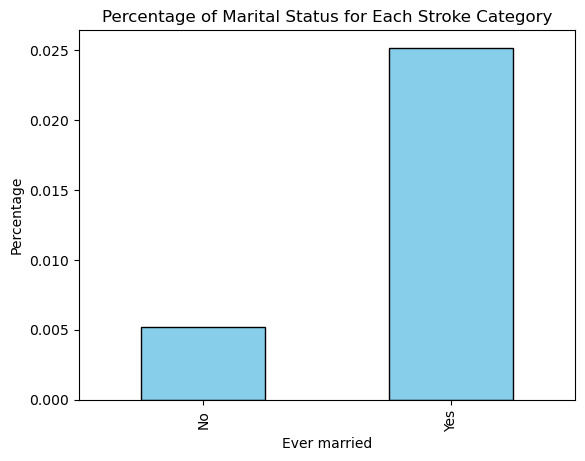

In [38]:
# Create a bar plot showing the percentage of marital status for each target category
df.groupby(['ever_married']) ['stroke'].mean().plot(kind='bar',  edgecolor = 'black', color = 'skyblue')
plt.xlabel('Ever married')
plt.ylabel('Percentage')
plt.title('Percentage of Marital Status for Each Stroke Category')
plt.show()

Our dataset indicates a higher proportion of individuals who are married, and this trend persists among individuals who have experienced a stroke. 

In [39]:
contingency_table = pd.crosstab(df['ever_married'], df['stroke'])

# Perform Chi-Squared Test
chi2_stat, p_val, _, _ = chi2_contingency(contingency_table)

# Print Chi-Square Statistic and p-value
print("Chi-Square Statistic:", chi2_stat)
print("p-value:", p_val)


Chi-Square Statistic: 223.3560107615051
p-value: 1.6763961138161355e-50


The Chi-square statistic is quite high, indicating a strong association between marital status and stroke. The p-value is extremely low (1.6764e-50), far below the commonly used significance threshold of 0.05. This suggests that the observed association is highly unlikely to be due to random chance.

### Work Type

Text(0, 0.5, 'Count')

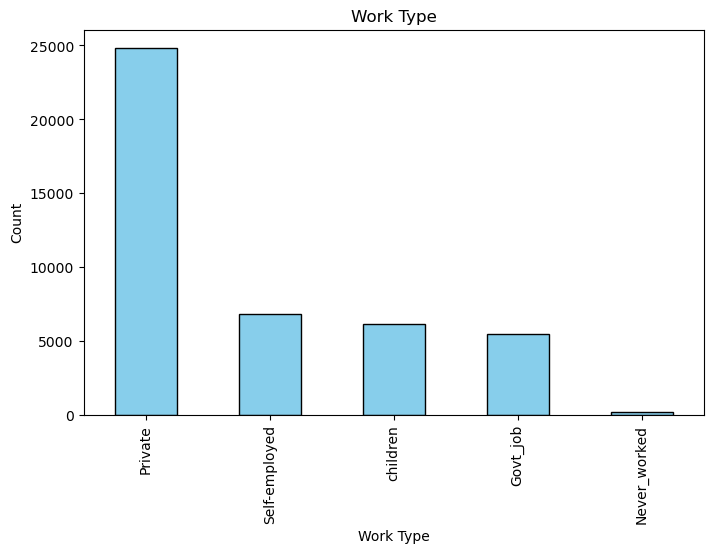

In [40]:
#Visually inspect work type column
ag = df['work_type'].value_counts().plot(kind='bar', figsize=(8, 5), edgecolor = 'black', color = 'skyblue')

# Set titles and labels
ag.set_title('Work Type')
ag.set_xlabel('Work Type')
ag.set_ylabel('Count')

In [41]:
df['work_type'].value_counts()

work_type
Private          24834
Self-employed     6793
children          6156
Govt_job          5440
Never_worked       177
Name: count, dtype: int64

In our dataset, the predominant category for work type is "private," indicating that a significant portion of individuals are employed in the private sector. Additionally, we observe a category labeled "never worked," which likely includes younger individuals who have not yet entered the workforce. Other categories such as self-employed, government jobs, and those involved in childcare (raising children) appear to be relatively similar in size.

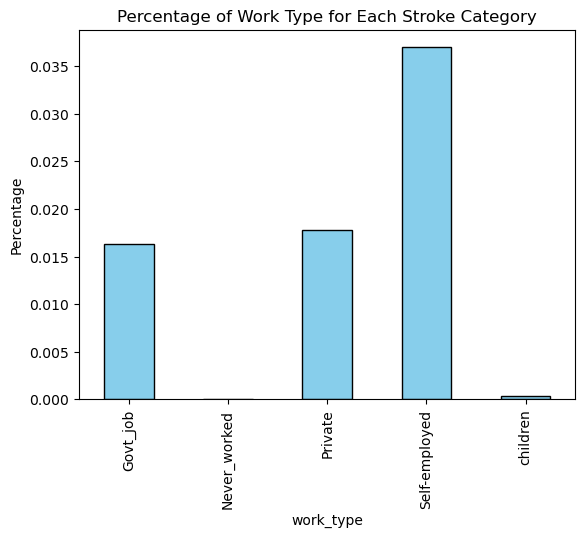

In [42]:
# Create a bar plot showing the percentage of heart disease for each target category
df.groupby(['work_type']) ['stroke'].mean().plot(kind='bar',  edgecolor = 'black', color = 'skyblue')
plt.ylabel('Percentage')
plt.title('Percentage of Work Type for Each Stroke Category')
#plt.legend(title='Heart Disease')
plt.show()

Upon comparing work types to stroke incidence, a noteworthy observation is that the majority of individuals who have experienced a stroke are self-employed, whereas the predominant category within our dataset comprises individuals employed in the private sector. This shift in the majority group suggests that work type may indeed influence stroke prediction. However, it is essential to conduct further analysis to explore potential confounding factors that could be contributing to this shift. Rigorous statistical testing will help ascertain the true relationship between work type and stroke prediction.

In [43]:
contingency_table = pd.crosstab(df['work_type'], df['stroke'])

# Perform Chi-Squared Test
chi2_stat, p_val, _, _ = chi2_contingency(contingency_table)

# Print Chi-Square Statistic and p-value
print("Chi-Square Statistic:", chi2_stat)
print("p-value:", p_val)


Chi-Square Statistic: 250.38868189317367
p-value: 5.368196953306683e-53


The Chi-square statistic is very high, indicating a strong association between work type and the occurrence of stroke. The p-value is extremely low (5.3682e-53), far below the commonly used significance threshold of 0.05. This implies that the observed association is highly unlikely to be due to random chance.

### Residence Type

Text(0, 0.5, 'Count')

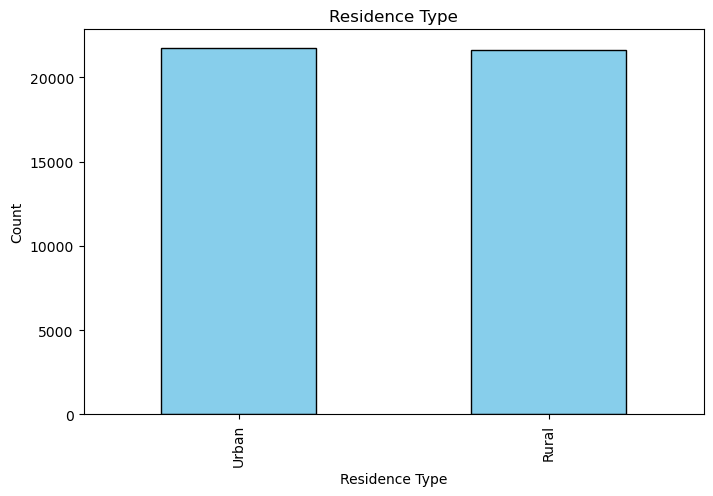

In [44]:
#Visually inspect residence type column
ag = df['Residence_type'].value_counts().plot(kind='bar', figsize=(8, 5), edgecolor = 'black', color = 'skyblue')

# Set titles and labels
ag.set_title('Residence Type')
ag.set_xlabel('Residence Type')
ag.set_ylabel('Count')

In [45]:
df['Residence_type'].value_counts()

Residence_type
Urban    21756
Rural    21644
Name: count, dtype: int64

We can see from our dataset shows an almost equal distribution between rural and urban residence types. This balanced split suggests that residence type may not exert a substantial influence on our stroke prediction models. While other factors within the dataset might have more significant predictive power, it's still essential to account for residence type in our analysis to ensure a comprehensive understanding of the potential factors contributing to stroke risk.

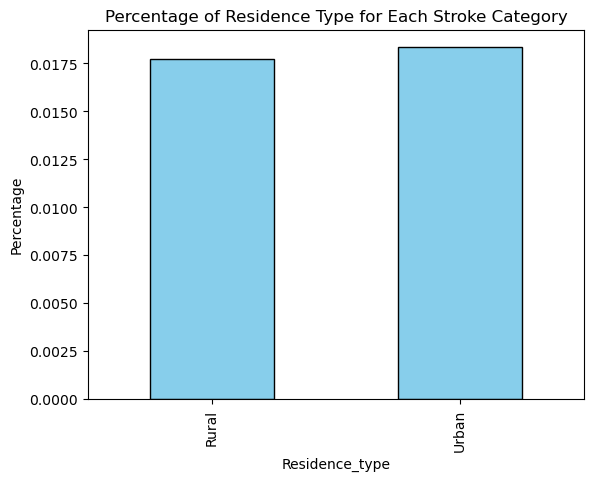

In [46]:
# Create a bar plot showing the percentage of residence type for each target category
df.groupby(['Residence_type']) ['stroke'].mean().plot(kind='bar',  edgecolor = 'black', color = 'skyblue')
plt.ylabel('Percentage')
plt.title('Percentage of Residence Type for Each Stroke Category')
#plt.legend(title='Heart Disease')
plt.show()

The comparison of residence type to stroke incidence mirrors the overall distribution within our dataset, with approximately an equal split between rural and urban residents. This parity suggests that residence type may not be a significant factor in stroke prediction. However, to confirm this observation and rule out any potential influence, further statistical analysis is warranted. Through rigorous testing, we can determine whether residence type indeed lacks predictive power in relation to strokes.

In [47]:
contingency_table = pd.crosstab(df['Residence_type'], df['stroke'])

# Perform Chi-Squared Test
chi2_stat, p_val, _, _ = chi2_contingency(contingency_table)

# Print Chi-Square Statistic and p-value
print("Chi-Square Statistic:", chi2_stat)
print("p-value:", p_val)


Chi-Square Statistic: 0.1866443482985896
p-value: 0.6657242966461914


The Chi-square statistic is relatively low, indicating a weak association between residence type and the occurrence of stroke. The p-value is quite high (0.6657), substantially greater than the commonly used significance threshold of 0.05. This suggests that the observed association is not statistically significant and could reasonably occur by random chance.

This implies that residing in urban or rural areas may not significantly impact an individual's risk of having a stroke. 

### Smokeing Status

Text(0, 0.5, 'Count')

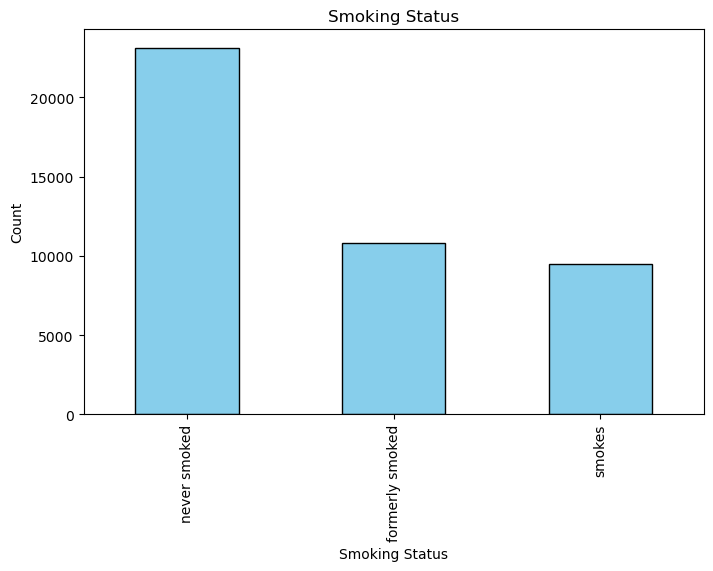

In [48]:
#Visually inspect smoking status column
ag = df['smoking_status'].value_counts().plot(kind='bar', figsize=(8, 5), edgecolor = 'black', color = 'skyblue')

# Set titles and labels
ag.set_title('Smoking Status')
ag.set_xlabel('Smoking Status')
ag.set_ylabel('Count')

In our dataset, the majority of individuals report never having smoked, comprising over half of the data. Approximately a quarter of the dataset consists of individuals who currently smoke. However, it's worth noting that almost 30% of values in the smoking type column were missing, which could impact the reliability of our analysis. Despite this missing data, the information on smoking status remains valuable for exploring its potential association with stroke risk among individuals with recorded data.

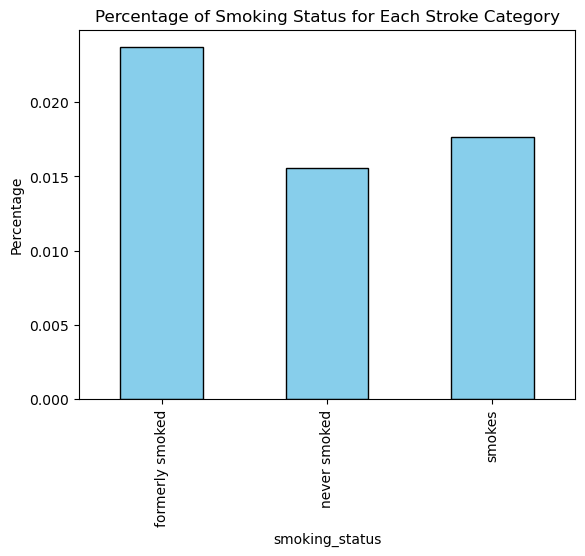

In [49]:
# Create a bar plot showing the percentage of smoking status for each target category
df.groupby(['smoking_status']) ['stroke'].mean().plot(kind='bar', edgecolor = 'black', color = 'skyblue')
plt.ylabel('Percentage')
plt.title('Percentage of Smoking Status for Each Stroke Category')
#plt.legend(title='Heart Disease')
plt.show()

The analysis reveals a notable shift in smoking status among individuals who have experienced a stroke compared to the overall dataset. While the majority of individuals in the dataset were never smokers, a larger proportion of stroke-positive individuals are former or current smokers. This discrepancy suggests that smoking status could indeed be a significant factor in predicting strokes. However, to confirm the strength of this association and assess its statistical significance, further robust analysis is imperative. Conducting thorough statistical tests will provide clarity on the role of smoking status in stroke prediction.

In [50]:
contingency_table = pd.crosstab(df['smoking_status'], df['stroke'])

# Perform Chi-Squared Test
chi2_stat, p_val, _, _ = chi2_contingency(contingency_table)

# Print Chi-Square Statistic and p-value
print("Chi-Square Statistic:", chi2_stat)
print("p-value:", p_val)


Chi-Square Statistic: 27.634533764060357
p-value: 9.98245217368656e-07


The Chi-square statistic is moderately high, indicating a notable association between smoking status and the occurrence of stroke. The p-value is extremely low (1.1689e-07), significantly lower than the commonly used significance threshold of 0.05. This suggests that the observed association is highly unlikely to be due to random chance.

This implies that smoking status is a significant factor influencing an individual's risk of having a stroke. It underscores the importance of smoking cessation efforts as a preventive measure against strokes. Further analysis could delve into specific smoking habits and their impact on stroke risk for more targeted interventions.

### Stroke

Text(0, 0.5, 'Count')

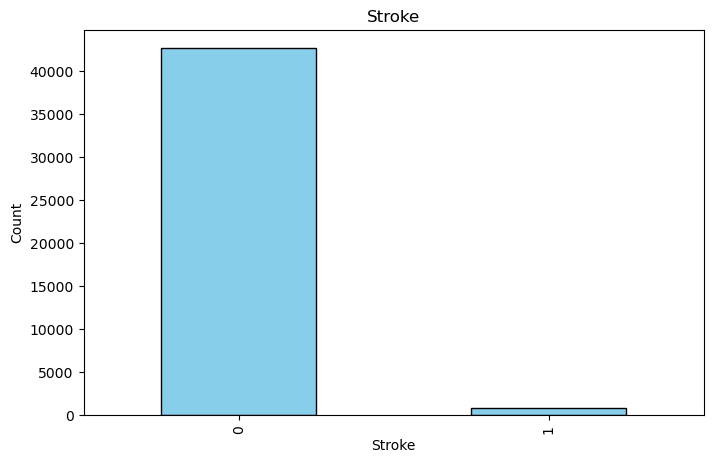

In [51]:
#Visually inspect our taret category stroke column
ag = df['stroke'].value_counts().plot(kind='bar', figsize=(8, 5), edgecolor = 'black', color = 'skyblue')

# Set titles and labels
ag.set_title('Stroke')
ag.set_xlabel('Stroke')
ag.set_ylabel('Count')

In [52]:
df['stroke'].value_counts()

stroke
0    42617
1      783
Name: count, dtype: int64

With the stroke column identified as our target variable, we observe that just under 2% of entries in our dataset indicate a history of stroke. This relatively low prevalence of stroke highlights the importance of investigating other potential contributing factors, such as high BMI, glucose levels, and smoking status, to understand their association with stroke risk. By analyzing these factors alongside the incidence of stroke, we can explore whether they contribute to an increased likelihood of stroke occurrence and assess their predictive value in identifying individuals at high risk for stroke.